<a href="https://colab.research.google.com/github/antonroycar/ChitChat/blob/main/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [ ]:
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device= torch.device("cpu")
  print(device)

cpu


# **Read a batch of training images along with their bounding boxes and labels.**

In this example, I use read only 1 image, i.e., batch_size=1.

(287, 273, 3)


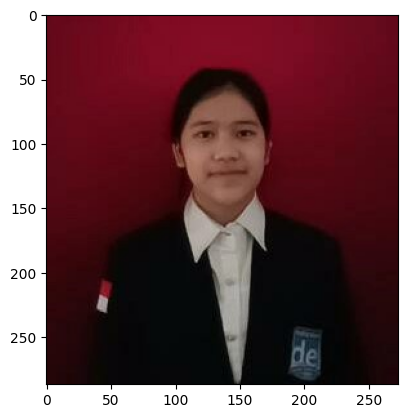

In [ ]:
# input image could be of any size
img0 = cv2.imread('niar_if_20.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [ ]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels
# bbox0 = np.array([[50, 100, 170, 200]]) --> Anton
bbox0 = np.array([[40, 90, 150, 180]]) # --> Niar
labels = np.array([1,1])  # 0: background, 1: face

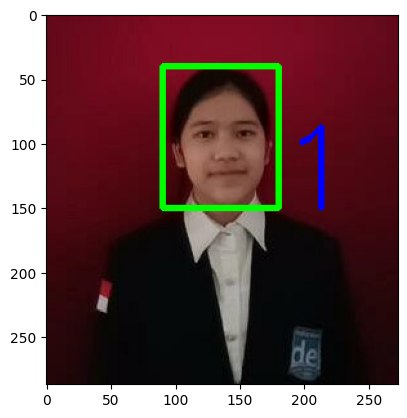

In [ ]:
# Assuming img0 is already defined; create a clone for drawing
img0_clone = np.copy(img0)

# Iterate over bounding boxes and labels
for i in range(len(bbox0)):
    # Draw each bounding box and label
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3)
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness=3)

# Display the image
plt.imshow(img0_clone)
plt.show()


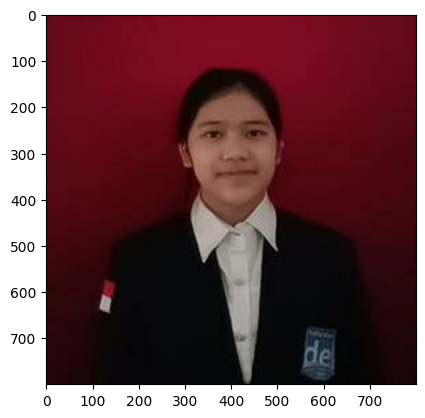

In [ ]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [ ]:
# change the bounding box coordinates
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[111 263 418 527]]


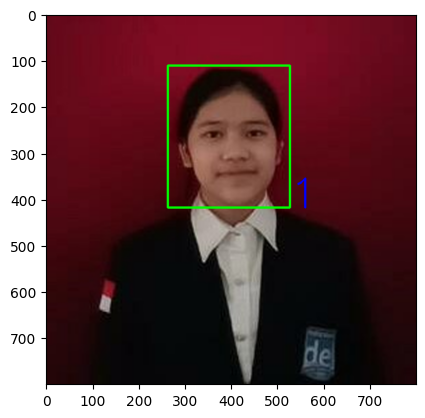

In [ ]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(0, 255, 0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox_clone[i][3], bbox_clone[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)
plt.imshow(img_clone)
plt.show()

# **Use VGG16 to extract features from input images.**

Input images (batch_size, H=800, W=800, d=3), Features: (batch_size, H=50, W=50, d=512)

In [ ]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.6MB/s]


31


In [ ]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float()  # test image array [1, 3, 800, 800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))  # 30
print(out_channels)  # 512

torch.Size([1, 3, 800, 800])
30
512


In [ ]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
# Assuming 'img' is a PIL Image or ndarray
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Apply the transformation to convert 'img' to a tensor and move it to the specified device
# Directly move img to the device if it's already a tensor
if torch.is_tensor(img):
    imgTensor = img.to(device)
else:
    # If img is a PIL Image or ndarray, apply the transform and then move to the device
    imgTensor = transform(img).to(device)


# Add a batch dimension
imgTensor = imgTensor.unsqueeze(0)

# Pass the tensor through the feature extractor
out_map = faster_rcnn_fe_extractor(imgTensor)

# Print the size of the output map
print(out_map.size())


torch.Size([1, 512, 50, 50])


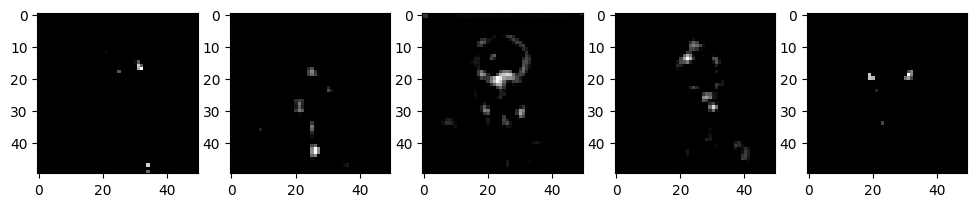

In [ ]:
# visualize the first 5 channels of the 50x50x512 feature maps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
plt.show()

In [ ]:
# x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1

print(ctr.shape)

(2500, 2)


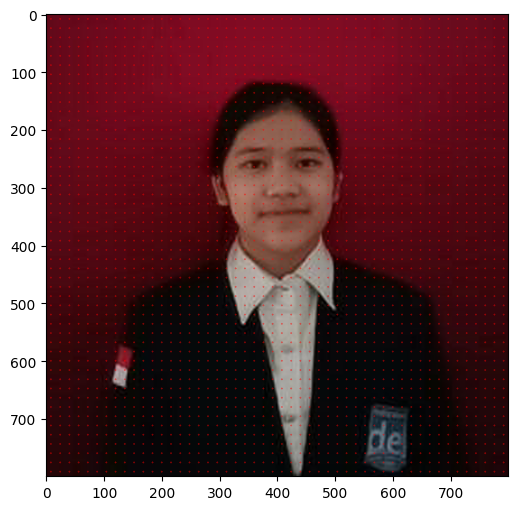

In [ ]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1)
plt.imshow(img_clone)
plt.show()

In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1

print(anchor_boxes.shape)


(22500, 4)


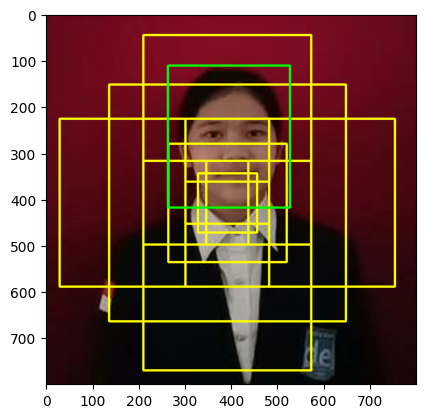

In [ ]:
# display the 9 anchor boxes of one anchor and the ground truth box
img_clone = np.copy(img)
for i in range(11025, 11034):  # 9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()


# **Calculate the IoU of valid anchor boxes with ground truth bboxes.**

In [ ]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>=0 and (y2, x2)<=800
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800)
)[0]

print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)


(8940,)
(8940, 4)


In [ ]:
# Calculate iou of the valid anchor boxes
# Since we have 8940 anchor boxes and 2 ground truth objects, we should get an array with (8940, 2) as the output.
ious = np.empty((len(valid_anchor_boxes), 1), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox0):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1] = iou
print(ious.shape)


(8940, 1)


In [ ]:
# What anchor box has max iou with the ground truth bbox
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[354]
[0.60424805]
[354 356 506 508 692 694]


In [ ]:
# What ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 0 0 0]
[0.04943038 0.04943038 0.04684762 ... 0.         0.         0.        ]


# **For IoU, the thresholds are 8940 for valid anchor boxes. Classification: 1 for object, 0 for background, -1 for ignore.**

In [ ]:
# Initialize the labels for each anchor
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)  # Initialize label as -1 (ignore)

print(label.shape)

(8940,)


In [ ]:
# Assign labels based on IOU values
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1  # Positive label for anchor with highest IOU
label[max_ious >= pos_iou_threshold] = 1  # Positive label for anchors with IOU above threshold
label[max_ious < neg_iou_threshold] = 0  # Negative label for anchors with IOU below threshold

# **For mini-batch training, take 256 valid anchor boxes to generate RPN, which consists of 128 positive examples and 128 negative examples. Valid anchor boxes not included in the mini-batch training will be labeled with -1 (ignore).**

In [ ]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = n_sample - np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
    label[disable_index] = -1


# **The format of valid anchor boxes is (y1, x, y2, x2) and the location loc = (cy-cya/ha), (cx-cxa/wa), log(h/ha), log(w/wa), where in the RPN, the anchor box is compared with the ground truth box to calculate the center y, center x, height, and width.**

In [ ]:
# For each valid anchor box, find the groundtruth object which has max_iou
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# valid anchor boxes #y, h, w, cx, cy
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

# Calculate anchor locations
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

# valid anchor boxes #y_loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(base_height, eps)
width = np.maximum(base_width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)


(8940, 4)
(8940, 4)


# **For the total of 22500 anchor boxes, set label=-1, location=0, and for the 8940 valid anchor boxes, set 128 labels as positive and 128 labels as negative, the rest label=-1.**

NOTICE: "During training epoch, for the 8940 valid anchor boxes, set 128 as positive + 128 as negative, the rest label=-1."

In [ ]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)


(22500,)
(22500, 4)


# **Use the extracted features to generate Region Proposal Network (RPN), and generate 22500 region proposals (ROIs).**

In [ ]:
in_channels = 512  # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)  # I will be going to use softmax here. you can equally use sigmoid if u want
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x = conv1(out_map.to(device))  # out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)


torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
# Adjust RPN train anchor box to the correct format
# From [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

# Adjust RPN train cls scores to the correct format
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

# Get objectness score from pred_cls_scores
objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

# Reshape pred_cls_scores
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)


torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


# **After the RPN generates 22500 ROIs, use 22500 anchor boxes to calculate RPN loss.**

In [ ]:
# Adjust the shapes of the predicted locations and scores to match the ground truth
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [ ]:
# Get the first element of predictions for RPN loss calculations
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

# Convert ground truth anchor locations and labels to tensors
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
# Calculate the RPN classification loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index=-1)
print(rpn_cls_loss)


tensor(0.6881, grad_fn=<NllLossBackward0>)


In [ ]:
# For Regression we use smooth L1 loss as defined in the Fast R-CNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([6, 4]) torch.Size([6, 4])
tensor(3.8434, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(7.0938, dtype=torch.float64, grad_fn=<AddBackward0>)


# **Use the 22500 ROIs generated by the RPN for Fast R-CNN to predict bbox + classifications. Apply NMS (Non-maximum suppression) to reduce the 22500 ROIs to 2000.**

In [ ]:
nms_thresh = 0.7  # non-maximum suppression (NMS)
n_train_pre_nms = 12000  # no. of train pre-NMS
n_train_post_nms = 2000  # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300  # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# The labelled 22500 anchor boxes
# format converted from [y1, x1, y2, x2] to [ctr_y, ctr_x, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]  # #get anchor box #9 dy
dx = pred_anchor_locs_numpy[:, 1::4]  # dx
dh = pred_anchor_locs_numpy[:, 2::4]  # dh
dw = pred_anchor_locs_numpy[:, 3::4]  # dw
print(dy.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)


(22500,)
(22500, 1)
(22500, 1)


In [ ]:
numpy_dtype = torch.tensor([], dtype=pred_anchor_locs.dtype).numpy().dtype

# Now use this numpy_dtype for defining your np.zeros array
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=numpy_dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to the image
img_size = (800, 800) # Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))


(22500, 4)
(22500, 4) 800.0 0.0


In [ ]:
# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] # min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

# Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)


(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [ ]:
# Take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# Find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)


In [ ]:
# Take the indexes of order the probability score in descending order
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0]  # take the 1st elt in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]

keep = keep[:n_train_post_nms]  # while training/testing, use accordingly
roi = roi[keep]  # the final region proposals
print(len(keep), roi.shape)


1759 (1759, 4)


# **After applying NMS, from the 2000 ROIs, select those with gt box ≥ iou to form 128 ROI samples, with positive ones being 128x0.25=32**

In [ ]:
n_sample = 128  # Number of samples from roi
pos_ratio = 0.25  # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5  # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5  # iou 0.0-0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0


In [ ]:
 ious = np.empty((len(roi), 2), dtype = np.float32)
 ious.fill(0)
 for num1, i in enumerate(roi):
        ya1, xa1, ya2, xa2 = i
        anchor_area = (ya2 - ya1) * (xa2 - xa1)

        # Iterate over each bounding box
        for num2, j in enumerate(bbox):
            yb1, xb1, yb2, xb2 = j
            box_area = (yb2 - yb1) * (xb2 - xb1)

            # Calculate the coordinates of the intersection rectangle
            inter_x1 = max(xb1, xa1)
            inter_y1 = max(yb1, ya1)
            inter_x2 = min(xb2, xa2)
            inter_y2 = min(yb2, ya2)

            # Check if there is an intersection
            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                iou = inter_area / (anchor_area + box_area - inter_area)
            else:
                iou = 0.0

            ious[num1, num2] = iou
print(ious.shape)

(1759, 2)


In [ ]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)
# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)


[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [ ]:
# Select the foreground rois as per the pos_iou_thresh and
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples.
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negative (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]

neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)

print(neg_roi_per_this_image)
print(neg_index)


12
[727 808 730 881 810 689 923 883 924 846 843 956]
116
[1423 1463 1745  537 1707  507  235  996  101  295  754  479  888  205
 1164  676  100  430   60 1015  569  333  619  838    0   65  172 1413
 1531 1040 1003   27 1324  107  467 1583  103  338  328 1624 1589  988
 1171 1355  410  441 1057  776 1532 1218 1234  981  596 1104 1263  389
   49    8  367 1328 1758  784 1638 1066  292 1679 1058 1716 1610  227
 1361  323  788 1064  538  381 1006 1050  683  449  105 1687  786 1344
  439  965  460 1429  347 1681  140  829  213 1179  146   45 1052 1357
 1499 1728  249  835 1244  216 1010  766 1231  137 1024 1161  212   96
  821 1351  641  598]


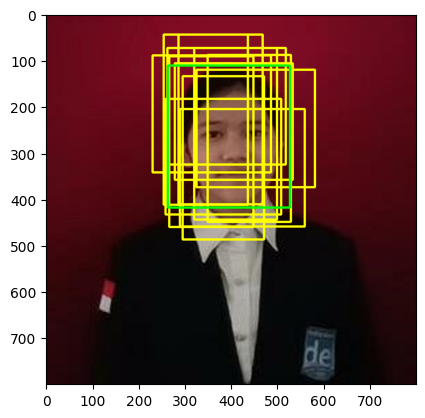

In [ ]:
# display ROI samples with positive
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3)  # Draw Rectangle

plt.imshow(img_clone)
plt.show()


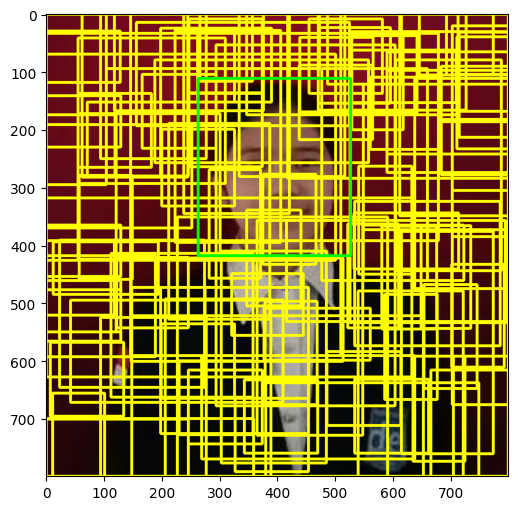

In [ ]:
# display ROI samples with negative
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3)  # Draw Rectangle

plt.imshow(img_clone)
plt.show()


In [ ]:
# Now we gather positive samples index and negative samples index,
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width


(128, 4)
(128, 4)


In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)


(128, 4)


# **Extract features from the 128 ROI samples, use max pooling to make them the same size, H=7, W=7 (ROI Pooling).**

In [ ]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 + np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)


torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])


In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)  # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)

# Ensure the indices are within bounds
max_idx = out_map.size(0) - 1

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0].clamp(0, max_idx)  # Clamp im_idx to be within [0, max_idx]
    # Ensure roi coordinates are within the image dimensions
    roi_end_y = min(roi[4].item() + 1, out_map.size(2))
    roi_end_x = min(roi[3].item() + 1, out_map.size(3))

    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:roi_end_y, roi[1]:roi_end_x]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])

output = torch.cat(output, 0)
print(output.size())


torch.Size([128, 512, 7, 7])


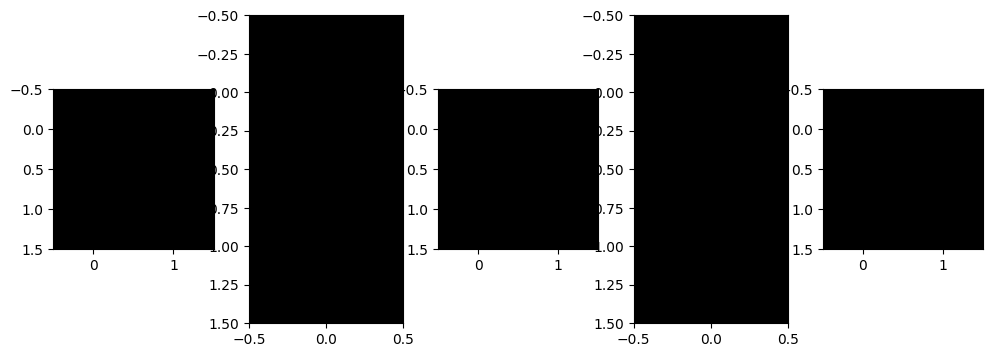

In [ ]:
# Assuming out_map, rois, and other necessary imports are defined
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)  # Assuming subsampling ratio is required as in the previous context
rois = rois.long()
num_rois = min(rois.size(0), 5)  # Only visualize the first 5 ROIs

fig = plt.figure(figsize=(12, 4))

for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0].clamp(0, out_map.size(0) - 1)  # Clamp index within valid range
    # Ensure roi coordinates are within the image dimensions
    roi_end_y = min(roi[4].item() + 1, out_map.size(2))
    roi_end_x = min(roi[3].item() + 1, out_map.size(3))

    # Adjusting the slicing to ensure it doesn't exceed bounds
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:roi_end_y, roi[1]:roi_end_x]
    if im.size(1) > 0:  # Ensure there's at least one channel to display
        tmp = im[0][0].detach().cpu().numpy()  # Select the first channel
        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(tmp, cmap='gray')
plt.show()




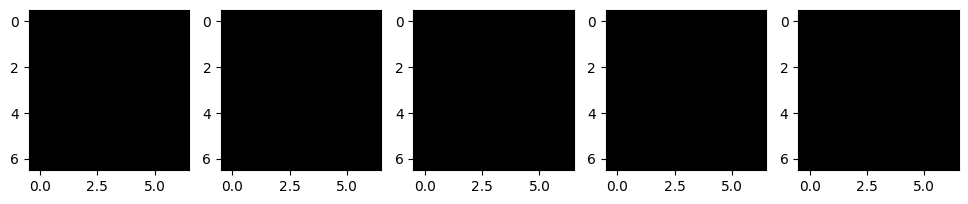

In [ ]:
output_size = (7, 7)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):  # Process only the first 5 ROIs
    roi = rois[i]
    im_idx = roi[0].clamp(0, out_map.size(0) - 1)
    roi_end_y = min(roi[4] + 1, out_map.size(2))
    roi_end_x = min(roi[3] + 1, out_map.size(3))

    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:roi_end_y, roi[1]:roi_end_x]

    # Ensure we have a non-empty tensor before proceeding
    if im.size(2) > 0 and im.size(3) > 0:
        # Apply adaptive max pooling to the selected ROI
        pooled = F.adaptive_max_pool2d(im, output_size)
        tmp = pooled[0][0].detach().cpu().numpy()  # Extract the first channel

        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(tmp, cmap='gray')

plt.show()

In [ ]:
# Reshape the tensor so that we can pass it thr ough the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512


torch.Size([128, 25088])


In [ ]:
roi_head_classifier = nn.Sequential(
    *[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device) # (1 classes #2#+ 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device) # (1 classes, #2#+ 1 background)


In [ ]:
# passing the output of roi-pooling to ROI head
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)


torch.Size([128, 8]) torch.Size([128, 2])


# **Calculate the loss of Fast R-CNN using the features (h, w, d=512) of the 128 ROIs matching the ground truth bounding boxes.**

In [ ]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

# actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)


torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

# Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)


torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [ ]:
#Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

#For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

#take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float()* (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([12, 4]) torch.Size([12, 4])
tensor(1.3853, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
roi_lambda = 10
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[1.1290, 0.8152, 0.8417, 0.6749],
        [0.6768, 0.6695, 1.6744, 2.7721],
        [0.7262, 0.8104, 1.3279, 2.1901],
        [0.9208, 0.6738, 0.8810, 1.5749],
        [0.6717, 0.6761, 0.6799, 0.9788],
        [0.7128, 0.8920, 0.6697, 0.7082],
        [0.7343, 0.7667, 0.7675, 1.1354],
        [0.7039, 0.7810, 1.3480, 1.7259],
        [0.6789, 0.8328, 0.6746, 0.7981],
        [0.7292, 0.6696, 0.7260, 1.1776],
        [0.8910, 0.7217, 0.7546, 0.7101],
        [0.6802, 1.0393, 1.3616, 1.2065]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
